In [1]:
import pandas as pd
df = pd.read_csv('/kaggle/input/netflix-prize-lite/netflix_interactions_lite.csv', usecols=[1,2,3])
df.head()

,userId,rating,movieId
0,785314,1.0,8
1,243963,3.0,8
2,1447783,4.0,8
3,1912665,1.0,8
4,1744889,1.0,8


In [2]:
users = df.userId.unique()
items = df.movieId.unique()

user_ids_dict = {value :ind  for ind, value in enumerate(users)}
movie_ids_dict = {value :ind  for ind, value in enumerate(items)}

In [3]:
import numpy as np

df.userId = df.userId.apply(lambda x: user_ids_dict[x])
df.movieId = df.movieId.apply(lambda x: movie_ids_dict[x])
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

df.head()

,userId,rating,movieId
0,0,1.0,0
1,1,3.0,0
2,2,4.0,0
3,3,1.0,0
4,4,1.0,0


In [4]:
train_indexs = np.random.rand(len(df)) <0.8
train_df = df[train_indexs]
test_df = df[~train_indexs]
train_df.shape, test_df.shape

((29754882, 3), (7438969, 3))

In [5]:
n_factors = 64
n_users = len(users)
n_items = len(items)

In [6]:
del df

In [7]:
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,userId,rating,movieId
0,1,3.0,0
1,2,4.0,0
2,3,1.0,0
3,4,1.0,0
4,5,3.0,0


In [8]:
train_indexs = np.random.rand(len(train_df)) <0.8
valid_df = train_df[~train_indexs]
train_df = train_df[train_indexs]
train_df.shape, valid_df.shape

((23802809, 3), (5952073, 3))

In [9]:
import keras
from keras.layers import Input, Embedding, Flatten
from keras.layers.merging import dot


user_input = Input(shape=(1, ), name='user_input', dtype="int64")
item_input = Input(shape=(1, ), name='item_input', dtype="int64")


user_embeddings = Embedding(n_users, n_factors, name='user_embeddings')(user_input)
item_embeddings = Embedding(n_items, n_factors, name='item_embeddings')(item_input)

user_vector = Flatten(name='user_vectors')(user_embeddings)
item_vector = Flatten(name='item_vectors')(item_embeddings)


similarity = dot([user_vector, item_vector], axes=1)

model = keras.models.Model([user_input, item_input], similarity)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
model.summary()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embeddings (Embedding)    (None, 1, 64)        4160000     ['user_input[0][0]']             
                                                                                                  
 item_embeddings (Embedding)    (None, 1, 64)        115200      ['item_input[0][0]']             
                                                                                              

In [10]:
hist = model.fit(x = [train_df.userId.values, train_df.movieId.values], y=train_df.rating, batch_size=4096*2, epochs=32, 
                    validation_data=([valid_df.userId.values, valid_df.movieId.values], valid_df.rating), verbose=1)

Epoch 1/32
2906/2906 [==============================] - 24s 6ms/step - loss: 12.6947 - val_loss: 7.6894
Epoch 2/32
2906/2906 [==============================] - 18s 6ms/step - loss: 2.7703 - val_loss: 0.9228
Epoch 3/32
2906/2906 [==============================] - 19s 7ms/step - loss: 0.8267 - val_loss: 0.8000
Epoch 4/32
2906/2906 [==============================] - 18s 6ms/step - loss: 0.7978 - val_loss: 0.7981
Epoch 5/32
2906/2906 [==============================] - 19s 7ms/step - loss: 0.7971 - val_loss: 0.7979
Epoch 6/32
2906/2906 [==============================] - 18s 6ms/step - loss: 0.7967 - val_loss: 0.7975
Epoch 7/32
2906/2906 [==============================] - 18s 6ms/step - loss: 0.7961 - val_loss: 0.7969
Epoch 8/32
2906/2906 [==============================] - 18s 6ms/step - loss: 0.7952 - val_loss: 0.7959
Epoch 9/32
2906/2906 [==============================] - 20s 7ms/step - loss: 0.7934 - val_loss: 0.7937
Epoch 10/32
2906/2906 [==============================] - 19s 7ms/step - 

In [11]:
del train_df, valid_df

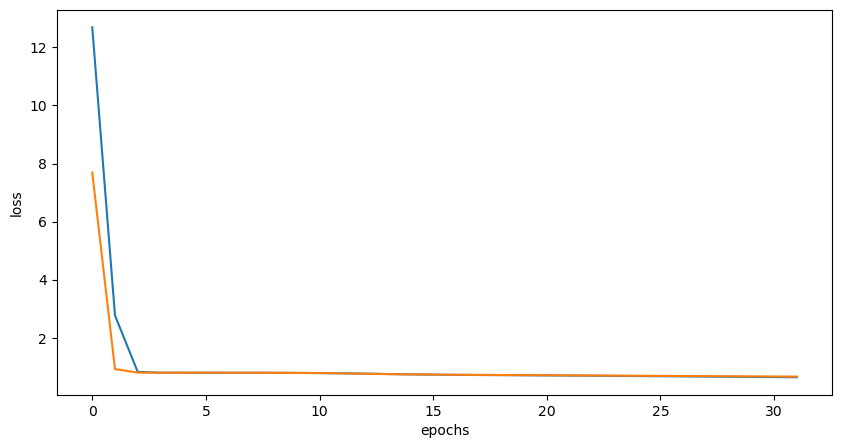

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

y_pred = model.predict([test_df.userId, test_df.movieId])

232468/232468 [==============================] - 375s 2ms/step


In [14]:
RMSE = mean_squared_error(test_df.rating, y_pred, squared=False)
RMSE

0.8151407

In [15]:
MAPE = mean_absolute_percentage_error(test_df.rating, y_pred)
MAPE

0.2352172